In [1]:
import os
import sys
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
from collections import deque
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from itertools import count
import random
import scipy.stats as stats
from tqdm import tqdm
import math 

from DAAN572_Project.policies import ContinuousPolicy
from DAAN572_Project.utils import compute_loss
from DAAN572_Project.utils import CVGA_score


In [2]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# configure module & syspath
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

# set device    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
from gym.envs.registration import register
register(
    id='simglucose-adolescent1-v0',
    entry_point='simglucose.envs:T1DSimEnv',
    kwargs={'patient_name': 'adolescent#002'}
)
env = gym.make('simglucose-adolescent1-v0')

/home/daniel/miniconda3/lib/python3.10/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [4]:
rewards_queue = deque()
rewards_ma = list()
run_duration = []
total_loss = []
state_lookback = 20
def get_num_params(lb):
    parms = (lb*3)+3
    return parms
num_state_features = get_num_params(state_lookback)
pi = ContinuousPolicy(num_state_features) 


In [ ]:
max_episodes = 100000
max_trajectory_length = 480
discount_factor = 0.95
epsilon = 0.95
running_bg = []
optimizer = optim.Adam(pi.parameters(), lr = 0.0001)


In [19]:
for epi in tqdm(range(max_episodes)):
       
#     failure_penalty = -999999        

    emergency_status = 0
    emergency_penalty = -1000
    
    ####################################
    ### INSTANTIATE OBSERVATION VARS ###
    ####################################
    observation = env.reset()
    observation = observation[0]
    observation = (observation - 39)/600
    observation_lag = observation
    observation_change = observation - observation_lag        
    observation_hist = np.zeros(state_lookback)
    for i in range(state_lookback):
        observation_hist[i] = observation_change
    observation_hist_norm = observation_hist
    
    
    #######################################
    ### INSTANTIATE ACTION HISTORY VARS ###
    #######################################
    insulin = 0.02
    insulin_norm = insulin / 30
    insulin_lag = insulin_norm
    insulin_hist = np.zeros(state_lookback)
    for i in range(state_lookback):
        insulin_hist[i] = insulin_norm
    insulin_hist_norm = insulin_hist

    
    ##############################################
    ### INSTANTIATE PLANNED MEAL HISTORY ARRAY ###
    ##############################################
    planned_meal = env.env.patient.planned_meal
    planned_meal_hist = np.zeros(state_lookback)
    planned_meal_hist_norm = planned_meal_hist
    planned_meal = 0
    planned_meal_lag = 0
    

    ################################################
    ### INSTANTIATE CUSTOM REWARD FUNCTION ARRAY ###
    ################################################
    CVGA_scores = []
    unobserved_CVGA_scores = np.zeros(8)    
    for i in range(8):
        unobserved_CVGA_scores[i] = -65    
        
    #################################
    ### INSTANTIATE CUR STATE VAR ###
    #################################
    
    state = np.concatenate((observation,observation_hist_norm,insulin_norm,insulin_hist_norm,planned_meal,planned_meal_hist_norm),axis=None).squeeze()


    ###############################
    ### LOOP THROUGH TRAJECTORY ###
    ###############################
    
    for t in range(max_trajectory_length):
        
        ########################
        ### DETERMINE ACTION ###
        ########################
        
        if random.uniform(0, 1) < epsilon:
            insulin = pi.act(torch.from_numpy(state.astype(np.float32)))[0]
        else:
            rec_insulin = pi.act(torch.from_numpy(state.astype(np.float32)))[0]
            a, b = 0, 30
            mu, sigma = rec_insulin, 2
            dist = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)
            insulin = dist.rvs(1)[0]          
                
        
        
        ######################
        ### PERFORM ACTION ###
        ######################
        observation, reward, done, _ = env.step(insulin)  
        
        
        ##########################################
        ### POPULATE OBSERVATION HISTORY ARRAY ###
        ##########################################
        observation = (observation[0] - 39)/600           # normalize glucose level to a value between 0 and 1
        observation_chg = observation - observation_lag   # create change value since previous time period
        observation_hist = np.roll(observation_hist,1)    # cycle the array by 1 position and move the oldest value from the rightmost position to first position
        observation_hist[0] = observation_chg             # replace first value in array (aka - the oldest value) with the most recent glucose change value
        
        # normalize the observation history into a new array for NN processing
        # the values are already normalized into the observable range of the CGM device of 39 to 600
        # so it is not required to use np.linalg function - just copy the array into new array for 
        # consistent naming convention
        observation_hist_norm = observation_hist     

            
            
        #####################################
        ### POPULATE ACTION HISTORY ARRAY ###
        #####################################
        insulin_norm = insulin / 30                       # normalize insulin val to restrict it to between 0 and 1
        insulin_chg = insulin_norm - insulin_lag               # create action change value since prev time period
        insulin_hist = np.roll(insulin_hist,1)            # cycle action array by 1 position move the oldest value from the rightmost position to the first position
        insulin_hist[0] = insulin_chg                     # replace first value in array (aka - the oldest value) with the most recent action change value
        
        # normalize the action history array into a new array for NN processing
        insulin_hist_norm = insulin_hist
        
          
        
        ###########################################
        ### POPULATE PLANNED MEAL HISTORY ARRAY ###
        ###########################################
        planned_meal = env.env.patient.planned_meal/100    # extract planned meal value of current state and divide by 100 to normalize the value
        planned_meal_chg = planned_meal - planned_meal_lag # create change value of planned meal since previous state
        planned_meal_hist = np.roll(planned_meal_hist,1)   # cycle planed meal array by 1 position move the oldest value from the rightmost position to the first position
        planned_meal_hist[0] = planned_meal_chg            # replace first value in array (aka - the oldest value) with the most recent action change value
        
        planned_meal_hist_norm = planned_meal_hist
        
#         # normalize the planned meal history into a new array for NN processing
#         if np.max(planned_meal_hist) == 0:
#             planned_meal_hist_norm = np.zeros(state_lookback)
#         else:
#             planned_meal_hist_norm = planned_meal_hist / np.linalg.norm(planned_meal_hist)     

            
        ####################################
        ### POPULATE CURRENT STATE ARRAY ###
        ####################################
        state = np.concatenate((observation,observation_hist_norm,insulin_norm,insulin_hist_norm,planned_meal,planned_meal_hist_norm),axis=None).squeeze()
            
            
        #####################################################
        ### MANIPULATE REWARDS VALUE WITH CUSTOM FUNCTION ###
        #####################################################
#         running_bg.append(observation)          
#         variability_score = 0
#         if t > 1 and t % 60 == 0:
#             min_bg = np.percentile(running_bg, 2.5) 
#             max_bg = np.percentile(running_bg, 97.5) 
#             bg_range = (min_bg,max_bg)
#             variability_score = -CVGA_score(bg_range)
#             period_idx = int(t/60) - 1
#             unobserved_CVGA_scores[period_idx] = 0
#             running_bg = []        
# #         if done:
#         if t == 480:
#             done = TRUE            
#             reward = reward + sum(unobserved_CVGA_scores)  

#         reward = reward + variability_score           

#         if reward > 0:
#             failure_penalty += reward

        
#         if done:
#             reward = reward + failure_penalty
        
        if reward > 0:
            emergency_penalty += 1
            
        if done:
            if emergency_status == 0:
                emergency_status = 1
                reward = emergency_penalty
                
        
        
        #######################################
        ### APPEND REWARDS TO REWARDS ARRAY ###
        #######################################
        pi.rewards.append(reward)
        
        
        ######################################################################
        ### REPOPULATE LAG VARS WITH CUR STATE VALS IN PREP OF NEXT ACTION ###
        ######################################################################
        observation_lag = observation
        planned_meal_lag = planned_meal
        insulin_lag = insulin_norm
        
#         if done:
#             break        
        
            
    ###################################
    ### COMPUTE LOSS AND SUM REWARD ###
    ###################################
    loss = compute_loss(pi, optimizer, discount_factor)
    total_loss.append(loss.item())
    total_reward = sum(pi.rewards)
    run_duration.append(t)
    
    
    ########################################
    ### RESET POLICY FOR NEXT TRAJECTORY ###
    ########################################
    pi.reset()
    
    
    #######################################
    ### CALCULATE MOVING AVERAGE REWARD ###
    #######################################
#     if len(rewards_queue) > state_lookback:
    if epi > 1:
        rewards_queue.popleft()
    rewards_queue.append(total_reward)
    mean_reward = np.mean(rewards_queue)
    rewards_ma.append(mean_reward)

    # Save the policy net
    if epi % 10 == 0:
        torch.save(pi.state_dict(), 'cont_policy_net3')
   
        
torch.save(pi.state_dict(), 'cont_policy_net3')

  0%|                                     | 26/100000 [01:48<115:32:10,  4.16s/it]capi_return is NULL
Call-back cb_fcn_in___user__routines failed.



KeyboardInterrupt: 

In [20]:
torch.save(pi.state_dict(), 'cont_policy_net3')

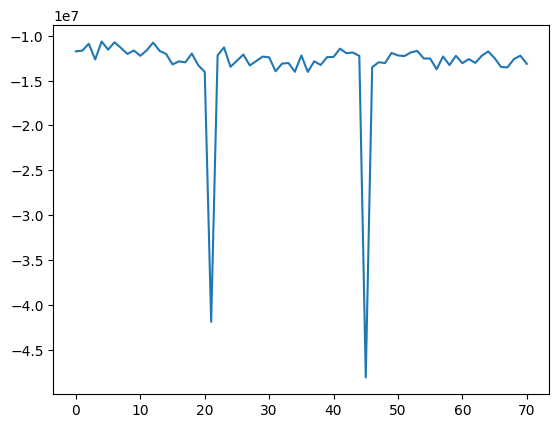

In [21]:
plt.plot(total_loss)

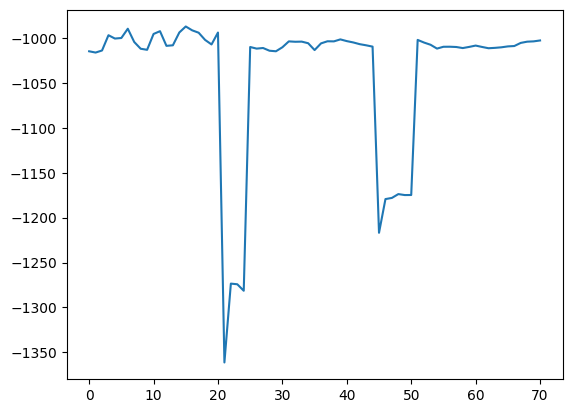

In [22]:
plt.plot(rewards_ma)

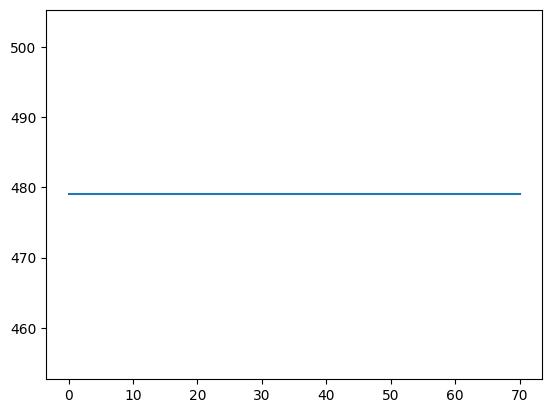

In [23]:
plt.plot(run_duration)

/home/daniel/miniconda3/lib/python3.10/site-packages/simglucose/simulation/env.py:174: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['CHO'] = pd.Series(self.CHO_hist)
/home/daniel/miniconda3/lib/python3.10/site-packages/simglucose/simulation/env.py:175: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['insulin'] = pd.Series(self.insulin_hist)


Complete


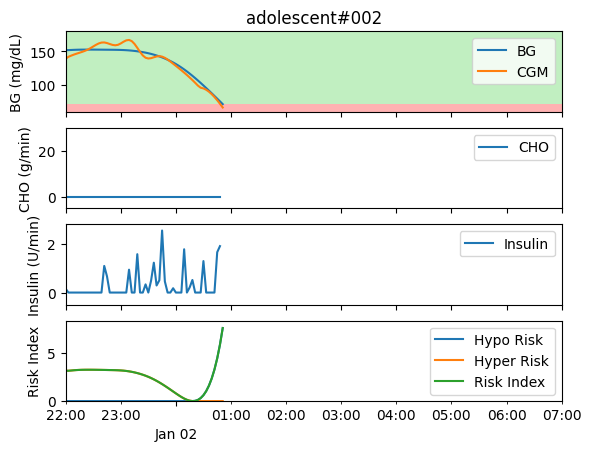

In [30]:

####################################
### INSTANTIATE OBSERVATION VARS ###
####################################
observation = env.reset()
observation = observation[0]
observation = (observation - 39)/600
observation_lag = observation
observation_change = observation - observation_lag        
observation_hist = np.zeros(state_lookback)
for i in range(state_lookback):
    observation_hist[i] = observation_change
observation_hist_norm = observation_hist


#######################################
### INSTANTIATE ACTION HISTORY VARS ###
#######################################
insulin = 0.025
insulin_norm = insulin / 30
insulin_lag = insulin_norm
insulin_hist = np.zeros(state_lookback)
for i in range(state_lookback):
    insulin_hist[i] = insulin_norm
insulin_hist_norm = insulin_hist


##############################################
### INSTANTIATE PLANNED MEAL HISTORY ARRAY ###
##############################################
planned_meal = env.env.patient.planned_meal
planned_meal_hist = np.zeros(state_lookback)
planned_meal_hist_norm = planned_meal_hist
planned_meal = 0
planned_meal_lag = 0


################################################
### INSTANTIATE CUSTOM REWARD FUNCTION ARRAY ###
################################################
CVGA_scores = []
unobserved_CVGA_scores = np.zeros(8)    
for i in range(8):
    unobserved_CVGA_scores[i] = -65    

#################################
### INSTANTIATE CUR STATE VAR ###
#################################

state = np.concatenate((observation,observation_hist_norm,insulin_norm,insulin_hist_norm,planned_meal,planned_meal_hist_norm),axis=None).squeeze()



for t in range(480):
    env.render(mode='human')
#     print(state)


    ########################
    ### DETERMINE ACTION ###
    ########################

#     if random.uniform(0, 1) < epsilon:
    insulin = pi.act(torch.from_numpy(state.astype(np.float32)))[0]



    ######################
    ### PERFORM ACTION ###
    ######################
    observation, reward, done, _ = env.step(insulin)  


    ##########################################
    ### POPULATE OBSERVATION HISTORY ARRAY ###
    ##########################################
    observation = (observation[0] - 39)/600           # normalize glucose level to a value between 0 and 1
    observation_chg = observation - observation_lag   # create change value since previous time period
    observation_hist = np.roll(observation_hist,1)    # cycle the array by 1 position and move the oldest value from the rightmost position to first position
    observation_hist[0] = observation_chg             # replace first value in array (aka - the oldest value) with the most recent glucose change value

    # normalize the observation history into a new array for NN processing
    # the values are already normalized into the observable range of the CGM device of 39 to 600
    # so it is not required to use np.linalg function - just copy the array into new array for 
    # consistent naming convention

    observation_hist_norm = observation_hist     

    # if np.max(observation_hist) == 0:
    #     observation_hist_norm = np.zeros(20)
    # else:
    #     observation_hist_norm = observation_hist / np.linalg.norm(observation_hist)   


    #####################################
    ### POPULATE ACTION HISTORY ARRAY ###
    #####################################
    insulin_norm = insulin / 30                       # normalize insulin val to restrict it to between 0 and 1
    insulin_chg = insulin_norm - insulin_lag               # create action change value since prev time period
    insulin_hist = np.roll(insulin_hist,1)            # cycle action array by 1 position move the oldest value from the rightmost position to the first position
    insulin_hist[0] = insulin_chg                     # replace first value in array (aka - the oldest value) with the most recent action change value

    # normalize the action history array into a new array for NN processing
    insulin_hist_norm = insulin_hist

    
    ###########################################
    ### POPULATE PLANNED MEAL HISTORY ARRAY ###
    ###########################################
    planned_meal = env.env.patient.planned_meal        # extract planned meal value of current state
    planned_meal_chg = planned_meal - planned_meal_lag # create change value of planned meal since previous state
    planned_meal_hist = np.roll(planned_meal_hist,1)   # cycle planed meal array by 1 position move the oldest value from the rightmost position to the first position
    planned_meal_hist[0] = planned_meal_chg            # replace first value in array (aka - the oldest value) with the most recent action change value

    # normalize the planned meal history into a new array for NN processing
    if np.max(planned_meal_hist) == 0:
        planned_meal_hist_norm = np.zeros(state_lookback)
    else:
        planned_meal_hist_norm = planned_meal_hist / np.linalg.norm(planned_meal_hist)     


    ####################################
    ### POPULATE CURRENT STATE ARRAY ###
    ####################################
    state = np.concatenate((observation,observation_hist_norm,insulin_norm,insulin_hist_norm,planned_meal,planned_meal_hist_norm),axis=None).squeeze()


    #####################################################
    ### MANIPULATE REWARDS VALUE WITH CUSTOM FUNCTION ###
    #####################################################
    running_bg.append(observation)          
    variability_score = 0
    if t > 1 and t % 60 == 0:
        min_bg = np.percentile(running_bg, 2.5) 
        max_bg = np.percentile(running_bg, 97.5) 
        bg_range = (min_bg,max_bg)
        variability_score = -CVGA_score(bg_range)
        period_idx = int(t/60) - 1
        unobserved_CVGA_scores[period_idx] = 0
        running_bg = []        
#         if done:
    if t == 480:
        done = TRUE            
        reward = reward + sum(unobserved_CVGA_scores)  

    reward = reward + variability_score              


    #######################################
    ### APPEND REWARDS TO REWARDS ARRAY ###
    #######################################
    pi.rewards.append(reward)


    ######################################################################
    ### REPOPULATE LAG VARS WITH CUR STATE VALS IN PREP OF NEXT ACTION ###
    ######################################################################
    observation_lag = observation
    planned_meal_lag = planned_meal
    insulin_lag = insulin_norm

    if done: 
        break    

            
print('Complete')
# plot_durations(show_result=True)
# plt.ioff()
# plt.show()
